# Setup

In [67]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from helper_functions import *

curr_dir = mkdirifnotexists(os.path.join('TaxaComposition')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 4-way stacked bar plots

## load data

In [12]:
acs_data = pd.read_csv('data/ACS_full_data.csv', index_col=0)
pnp_data = pd.read_csv('data/pnp1_full_data.csv', index_col='RegistrationCode')
pnp_data = pnp_data[pnp_data.IsGenotek == 0]
pnp_data = pnp_data[pnp_data.Nextera == 'True']
acs_data['ACS sample'] = 1
pnp_data['ACS sample'] = 0

acs_199 = acs_data['k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii|fSGB__222|gSGB__534|sSGB__714'].dropna().index

data = pd.concat((acs_data, pnp_data), axis=0, sort=False).filter(regex='k__|Age|gender|ACS sample').copy()
print (data.shape)

mb_data = remove_rare_elements(data.filter(regex='k__').dropna(how='all').T, rare_def=0.05, null=False).T
print (mb_data.shape)

data = pd.concat((data.filter(regex='Age|gender|ACS sample'), mb_data), axis=1).dropna(how='any')
print (data.shape)
# data['const'] = 1


matched_samples = pd.read_csv(os.path.join('Matching', 'PNP1-ACS_matching', 'PNP1-ACS_microbiome_age+sex+bmi+DM+smoking_1:1.csv'), index_col=0)
matched_pnp_data = data.loc[matched_samples[matched_samples['ACS sample'] == 0].index]
matched_acs_data = data.loc[matched_samples[matched_samples['ACS sample'] == 1].index]
matched_data = data.loc[matched_samples.index].copy()

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(542, 2976)
removing 0.742 of elements.
(539, 768)
(534, 771)


## compute mean taxa

In [14]:
bacteria = ['Verrucomicrobia', 'Actinobacteria', 'Proteobacteria', 'unknown', 'Bacteroidetes', 'Firmicutes']

In [15]:
def compute_taxa_mean(data):
    mb_full_phyla = data.filter(regex='k__').copy()
    # mb_full_phyla = acs_data[(acs_data['gender'] == 1)].filter(regex='k__').copy()
    mb_full_phyla.columns = [s.split('|')[1].split('__')[1] for s in mb_full_phyla.columns]
    mb_full_phyla = mb_full_phyla.T.reset_index().groupby('index').sum()
    mb_full_phyla = mb_full_phyla.loc[bacteria]
    mb_full_phyla = mb_full_phyla.apply(lambda x: x/x.sum(), axis=0)
    mb_full_phyla = mb_full_phyla.loc[mb_full_phyla.mean(1).sort_values(ascending=False).index].T.sort_values('Firmicutes', ascending=False)
    return mb_full_phyla

In [18]:
matched_acs_mb_full_phyla = compute_taxa_mean(matched_acs_data.filter(regex='k__').copy())
matched_pnp_mb_full_phyla = compute_taxa_mean(matched_pnp_data.filter(regex='k__').copy())
acs_mb_full_phyla = compute_taxa_mean(data[data['ACS sample']==1].filter(regex='k__').copy())
pnp_mb_full_phyla = compute_taxa_mean(data[data['ACS sample']==0].filter(regex='k__').copy())

In [66]:
matched_acs_mb_full_phyla.to_csv(os.path.join(curr_dir, 'matched_acs_mb_full_phyla.csv'))
matched_pnp_mb_full_phyla.to_csv(os.path.join(curr_dir, 'matched_pnp_mb_full_phyla.csv'))
acs_mb_full_phyla.to_csv(os.path.join(curr_dir, 'acs_mb_full_phyla.csv'))
pnp_mb_full_phyla.to_csv(os.path.join(curr_dir, 'pnp_mb_full_phyla.csv'))

Firmicutes
(-1542.0, 0.007998130290717467)


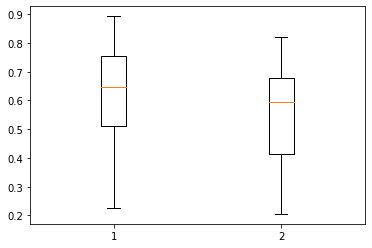

Bacteroidetes
(1733.0, 0.0669660046424479)


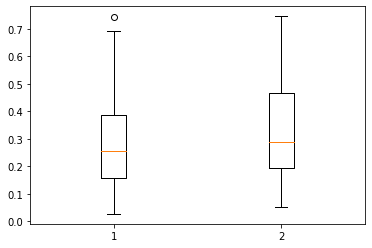

Proteobacteria
(1404.0, 0.0010823574281896681)


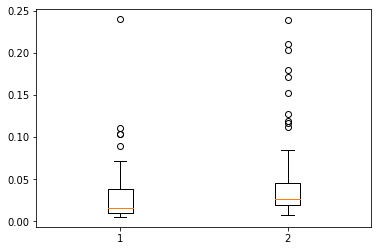

unknown
(1908.0, 0.2530897054780036)


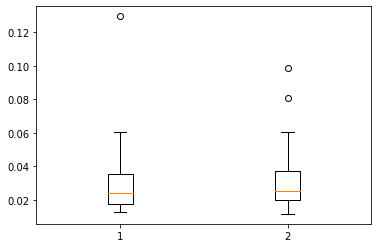

Actinobacteria
(1839.0, 0.16020310010962463)


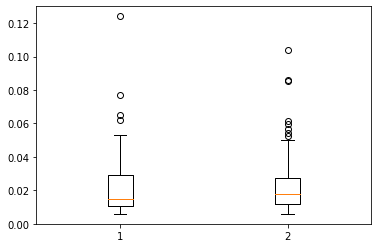

Verrucomicrobia
(1796.0, 0.11535275891292479)


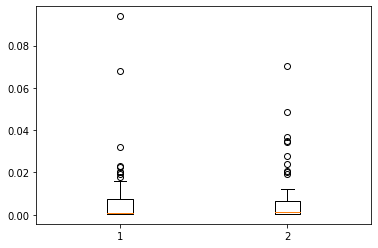

In [28]:
for c in matched_acs_mb_full_phyla.columns:
    print (c)
    plt.boxplot([matched_pnp_mb_full_phyla[c].values, matched_acs_mb_full_phyla[c].dropna()])
    print (directed_mannwhitneyu(matched_pnp_mb_full_phyla[c], matched_acs_mb_full_phyla[c].dropna()))
    plt.show()
# #     
# matched_acs_mb_full_phyla

Firmicutes
(-25777.0, 5.872421818713566e-06)


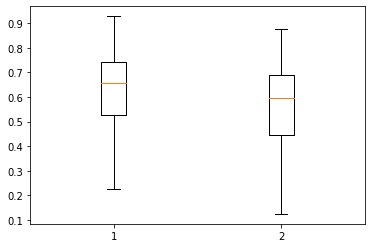

Bacteroidetes
(28541.0, 0.0027261965919781273)


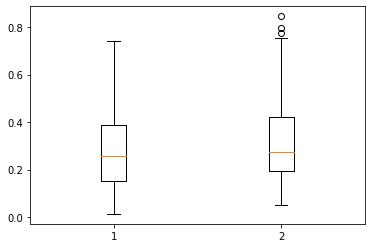

Proteobacteria
(19123.0, 8.473564716468747e-17)


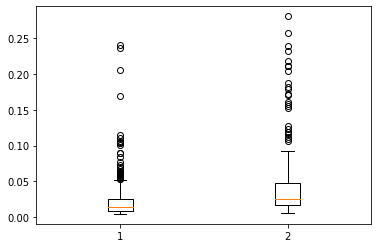

unknown
(28105.0, 0.0012150305615165296)


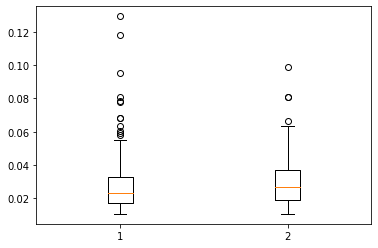

Actinobacteria
(-29220.0, 0.00853579906040663)


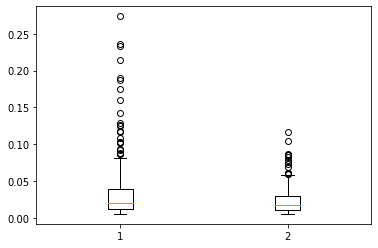

Verrucomicrobia
(30438.0, 0.04660894616286337)


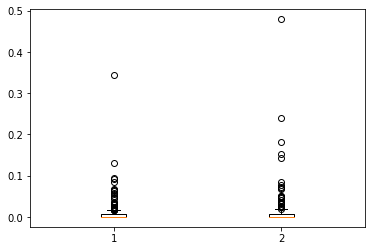

In [29]:
for c in acs_mb_full_phyla.columns:
    print (c)
    plt.boxplot([pnp_mb_full_phyla[c].values, acs_mb_full_phyla[c].dropna()])
    print (directed_mannwhitneyu(pnp_mb_full_phyla[c], acs_mb_full_phyla[c].dropna()))
    plt.show()
# #     
# matched_acs_mb_full_phyla

In [65]:
from scipy.stats import kruskal

(335, 6)

In [61]:
for phylum in bacteria:
    t, p  = kruskal(pnp_mb_full_phyla.loc[:, phylum], acs_mb_full_phyla.loc[:, phylum])
    print (phylum, p)
    t, p  = kruskal(matched_pnp_mb_full_phyla.loc[:, phylum], matched_acs_mb_full_phyla.loc[:, phylum])
    print (phylum, p)

Verrucomicrobia 0.09316135068120913
Verrucomicrobia 0.22977981402188252
Actinobacteria 0.017058143409196133
Actinobacteria 0.3192470902443482
Proteobacteria 1.690608882111303e-16
Proteobacteria 0.0021475234476868847
unknown 0.0024277273770866425
unknown 0.5046563693176223
Bacteroidetes 0.005447527010521832
Bacteroidetes 0.13331475149449282
Firmicutes 1.172921440013394e-05
Firmicutes 0.015892121860562002


## plot

Text(-0.25, 1, 'a')

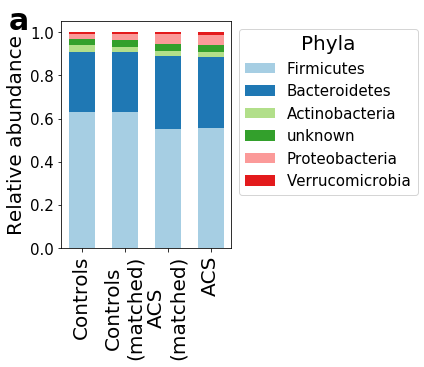

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
labels_fontsize = 20
tick_fontsize = 15

labels = ['Controls', 'Controls\n(matched)', 'ACS\n(matched)', 'ACS']
width=0.6

df_mean = pd.concat((pnp_mb_full_phyla.mean(), matched_pnp_mb_full_phyla.mean(), matched_acs_mb_full_phyla.mean(), acs_mb_full_phyla.mean()), axis=1).sort_values(0, ascending=False)
df_std = pd.concat((pnp_mb_full_phyla.std(), matched_pnp_mb_full_phyla.std(), matched_acs_mb_full_phyla.std(), acs_mb_full_phyla.std()), axis=1)

paired_colors = sns.color_palette('Paired', df_mean.shape[0])
for i, color in zip(range(df_mean.shape[0]), paired_colors):
    label = df_mean.index[i]
    if i == 0:
        ax.bar(labels, df_mean.loc[label], width, label=label, color=color) #  yerr=df_std.loc[label]
    else:
        ax.bar(labels, df_mean.loc[label], width, label=label, bottom=df_mean.head(i).sum(), color=color)
ax.tick_params(labelsize=15)
ax.set_ylabel('Relative abundance', fontsize=labels_fontsize)
ax.set_xticklabels(labels, fontsize=20, rotation=90)

leg = ax.legend(ncol=1, loc='upper left' , bbox_to_anchor=(1, 1),
                  fontsize=tick_fontsize, frameon=True, labelspacing=0.5, title='Phyla')
leg.get_title().set_fontsize(str(labels_fontsize))

fig.tight_layout()
plt.text(-0.25, 1, 'a', ha='center', va='center', transform=ax.transAxes, fontsize=30, weight = 'bold')

# plt.savefig(os.path.join(curr_dir, 'stacked_barplot_matched_small.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(curr_dir, 'stacked_barplot_matched.png'), dpi=1200, bbox_inches='tight')

In [54]:
required_data_for_plot = {'df_mean':df_mean, 'df_std':df_std}
with open(os.path.join(curr_dir, 'required_data_for_plot.pkl'), 'wb') as handle:
    pickle.dump(required_data_for_plot, handle)